# 12.16 课后作业： 股票时间序列分析
------

本次作业将使用线性自回归模型和简单的神经网络模型对某公司每日收盘价格序列进行分析和预测。

In [1]:
import csv, time
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt

In [2]:
filename = 'GOOGL_2006-01-01_to_2018-01-01.csv'
# skip the header. extract the 4th column ("close")
data = torch.from_numpy(np.loadtxt(filename, skiprows=1, delimiter=",", usecols=4)).float()
Len = len(data)
print("Totally", Len, "time steps.")

Totally 3019 time steps.


在$K$阶的自回归模型中，我们对时间序列建模如下：对任意$t$，
$$
x_{t} = f_\theta(x_{t-K}, x_{t-K+1}, ..., x_{t-1}) + \epsilon_{t},
$$
其中$\epsilon_t \sim \mathcal{N}(0, \sigma^2)$.

为了求出最优的模型参数$\theta$，我们求解这样的优化问题：
$$
\min_{\theta} \mathcal{L}_\text{train}(\theta) := \sum_{t\in \mathcal{I}_{\text{train}}} \Vert f_\theta(x_{t-K}, x_{t-K+1}, ..., x_{t-1}) - x_t \Vert_2^2
$$

在线性自回归模型中，我们设$f_\theta(x_1, ..., x_K) = w_0 + \sum_{k=1}^K w_kx_k$是一个线性模型，其中参数$\theta = \{w_0, w_1, ..., w_K\}$；而在神经网络模型中，$f_\theta$可以拟合更加复杂的映射。

-----
下面首先定义一个`Pytorch`中的标准数据集类，这是个可以随机访问和迭代的对象。

In [3]:
class StockDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, K):
        self.data = data
        self.K = K
    
    def __len__(self):
        return len(self.data) - self.K
    
    def __getitem__(self, idx): # return the `idx` - th object (x, y) in the dataset
        return ( torch.cat((self.data[idx : idx + K],torch.ones(1))), 
                self.data[idx + K].unsqueeze(0) )# insert a new axis

## 1. 线性自回归模型

In [4]:
K = 30

In [5]:
train_data = StockDataset(data[:-500], K)
test_data = StockDataset(data[-500:], K)

In [6]:
# train_data 可迭代
for x, y in train_data:
    print(x, y)
    break

tensor([217.8300, 222.8400, 225.8500, 233.0600, 233.6800, 235.1100, 236.0500,
        232.0500, 233.3600, 233.7900, 222.6800, 218.4400, 199.9300, 213.9600,
        221.7400, 216.7200, 217.3500, 216.9600, 213.6200, 216.5500, 201.0900,
        198.2200, 190.9700, 192.7400, 184.1400, 184.7200, 179.5600, 181.4900,
        173.0200, 171.8300,   1.0000]) tensor([171.3600])


训练集的$X \in \mathbb{R}^{N \times (K+1)}$和$y \in \mathbb{R}^{N\times 1}$。$X$的每一行表示一个$K+1$维数据点（新加的一维用来把常数项放进求和号中，简化表达），各个点的回归目标保存在$y$中。

In [7]:
X = torch.stack([x for x, _ in train_data])
y = torch.stack([y for _, y in train_data])
print(X.shape,y.shape)

torch.Size([2489, 31]) torch.Size([2489, 1])


设线性模型参数$w\in \mathbb{R}^{K+1}$，则正规方程$\min_w \Vert Xw - y \Vert_2^2$的解为$\hat{w} = (X^TX)^{-1}X^Ty$. 

**请你在下面补充代码，求出最优的参数$\hat{w}$。**

In [8]:
W = torch.inverse(X.T@X)@X.T@y
print(W.shape)

torch.Size([31, 1])


**请你在下面补充代码，检查求出的模型在测试集`test_data`上的表现，求出测试集上的平均均方误差。**

In [9]:
X_test = torch.stack([x for x, _ in test_data])
y_test = torch.stack([y for _, y in test_data])
loss = (X_test@W-y_test).square().mean()
print(loss)

tensor(78.2956)


**计算模型在整个序列上的估计值，并可视化。** 结合系数`w`，你发现了什么现象，如何解释模型的行为？

torch.Size([3019])


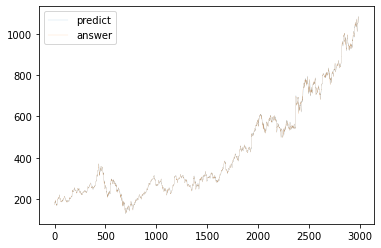

In [10]:
print(data.shape)
data_loader=StockDataset(data,K)
X_all=torch.stack([x for x,_ in data_loader])
y_hat = torch.cat((data[:K],(X_all@W).view(-1)))
y_hat=(X_all@W).view(-1)
plt.plot(y_hat,label='predict',lw=0.1)
plt.plot(data[K:],label='answer',lw=0.1)
plt.legend()

In [11]:
W

tensor([[ 3.6052e-02],
        [-8.5631e-02],
        [ 3.2788e-02],
        [ 1.3416e-02],
        [ 6.8470e-02],
        [-7.0262e-02],
        [ 3.1907e-02],
        [-2.9319e-02],
        [-5.1677e-03],
        [-2.8600e-02],
        [ 1.9813e-02],
        [ 1.3619e-02],
        [-6.2903e-02],
        [ 6.1167e-02],
        [ 7.6757e-03],
        [ 1.0774e-02],
        [ 9.3035e-03],
        [-1.4839e-02],
        [-7.8709e-03],
        [-1.6911e-02],
        [ 2.1192e-02],
        [-8.4238e-03],
        [ 1.7081e-02],
        [ 7.9012e-04],
        [-1.5018e-02],
        [ 1.4981e-02],
        [ 1.3867e-02],
        [-1.1079e-02],
        [-4.3549e-02],
        [ 1.0268e+00],
        [ 8.9891e-02]])


**调整窗口宽度$K$的大小，对比Loss，你有什么发现？**

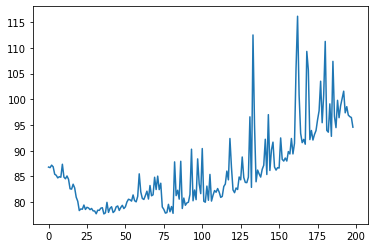

In [12]:
loss=[]
for K in range(1,200):
    train_data = StockDataset(data[:-500], K)
    test_data = StockDataset(data[-500:], K)
    X = torch.stack([x for x, _ in train_data])
    y = torch.stack([y for _, y in train_data])
    W = torch.inverse(X.T@X)@X.T@y
    X_test = torch.stack([x for x, _ in test_data])
    y_test = torch.stack([y for _, y in test_data])
    loss.append((X_test@W-y_test).square().mean().item())
plt.plot(loss)
    

这个W几乎就是在输出前一天的值。。然后测试集上的loss大致是一个关于K的凹函数，在30左右取得最小值，在30以后剧烈波动，但总体趋势是增加

## 2. 神经网络模型

在这里，我们设计一个简单的两到三层的神经网络来预测时间序列。

首先将训练集进一步抽出一部分作为验证集。

In [13]:
K = 30
train_data = StockDataset(data[:-500], K)
test_data = StockDataset(data[-500:], K)
train_size = int(0.9 * len(train_data))
valid_size = len(train_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, valid_size])

构造`Pyrorch`中标准的`DataLoader`类。你可以更改其中的参数。

In [14]:
train_iter  = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 64)
valid_iter = torch.utils.data.DataLoader(valid_data, batch_size = 64)
test_iter = torch.utils.data.DataLoader(test_data, batch_size = 64)

**定义模型及损失函数。** 提示：为了加速训练，你可以考虑在forward中，先对网络的输入（每个长度为K的片段）进行归一化。

In [15]:
from collections import OrderedDict
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(OrderedDict(
            # nm1=nn.BatchNorm1d(1),
            # cv1=nn.Conv1d(1,10,kernel_size=5),
            # nm2=nn.BatchNorm1d(10),
            # rl1=nn.ReLU(),
            # mp1=nn.MaxPool1d(kernel_size=4,stride=4),
            # cv2=nn.Conv1d(10,100,kernel_size=5),
            # nm3=nn.BatchNorm1d(100),
            # rl2=nn.ReLU(),
            # nm1=nn.BatchNorm1d(1),
            ft1=nn.Flatten(),
            # fc1=nn.Linear(K,100),
            # rl3=nn.ReLU(),
            # fc3=nn.Linear(100,100),
            # rl4=nn.ReLU(),
            fc2=nn.Linear(K+1,1)
        ))
        
    def forward(self, X):
        return self.net(X)

net = MyModel()
print(net)

MyModel(
  (net): Sequential(
    (ft1): Flatten(start_dim=1, end_dim=-1)
    (fc2): Linear(in_features=31, out_features=1, bias=True)
  )
)


In [16]:
loss = nn.MSELoss()

训练模型。`evaluate_model`用于评估模型`net`在`data_iter`上的表现，给出平均损失；`train`会在`train_iter`上训练模型`net`，优化器选择`optimizer`，并用`valid_iter`进行验证及early stop。

**请你完善以下代码。**代码仅供参考，觉得不方便的地方，可以直接修改。

提示：如果你是用cuda进行训练，请务必把网络和需要在GPU上进行运算的tensor移动到GPU上。参与运算的两个tensor必须同时在GPU显存或CPU内存中。

In [17]:
from utils import EarlyStop

device = "cuda" if torch.cuda.is_available() else "cpu"

def evaluate_model(data_iter, net, loss, device = device):
    loss_sum, n = 0.0, 0
    net = net.to(device)
    with torch.no_grad():
        net.eval() 
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            X=X.view(X.shape[0],1,X.shape[1])
            # print(X.shape)
            pred=net(X)
            loss_sum+=loss(pred,y).item()*y.shape[0]
            n+=y.shape[0]
        net.train()
    return loss_sum / n

def train(net, train_iter, valid_iter, loss, optimizer, max_epochs = 100, early_stop = None, device = device):
    
    net = net.to(device)
    print("training on ", device)
    
    for epoch in range(max_epochs):
        
        train_loss, n, start = 0.0, 0, time.time()
        for X, y in train_iter:
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            X=X.view(X.shape[0],1,X.shape[1])
            # print(X.shape)
            pred=net(X)
            l=loss(pred,y)
            train_loss += l.cpu().item() * y.shape[0]
            n += y.shape[0]
            l.backward()
            optimizer.step()
        valid_loss = evaluate_model(valid_iter,net,loss)
        train_loss/=n
        print('epoch %d, train loss %.8f , valid loss %.8f, time %.1f sec' % (epoch, train_loss, valid_loss, time.time() - start))
        
        if (early_stop):
            if (early_stop(valid_loss, net, optimizer)):
                break
    
    if (early_stop):
        checkpoint = torch.load(early_stop.save_name)
        net.load_state_dict(checkpoint["net"])

In [18]:
def init_parameters(n):
    if isinstance(n, nn.Linear):
        nn.init.xavier_uniform_(n.weight)
net.apply(init_parameters)
# for p in net.parameters():
#     print(p)
train(net, train_iter, valid_iter, loss, 
      optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.01, weight_decay = 0.0001), 
      max_epochs = 100, early_stop = EarlyStop(patience = 100))

training on  cuda
epoch 0, train loss 5067.39204450 , valid loss 1542.91581021, time 0.1 sec
epoch 1, train loss 1117.74185093 , valid loss 971.85499714, time 0.1 sec
epoch 2, train loss 954.22163609 , valid loss 865.00625843, time 0.1 sec
epoch 3, train loss 899.85359584 , valid loss 799.15886177, time 0.1 sec
epoch 4, train loss 873.55004447 , valid loss 702.49332217, time 0.1 sec
epoch 5, train loss 715.29777745 , valid loss 649.87869692, time 0.1 sec
epoch 6, train loss 622.72635149 , valid loss 687.78698730, time 0.1 sec
EarlyStopping counter: 1 out of 100
epoch 7, train loss 587.56286970 , valid loss 532.56303559, time 0.1 sec
epoch 8, train loss 511.61600691 , valid loss 488.18072681, time 0.1 sec
epoch 9, train loss 463.50118931 , valid loss 423.79659274, time 0.1 sec
epoch 10, train loss 426.21262817 , valid loss 482.64760335, time 0.1 sec
EarlyStopping counter: 1 out of 100
epoch 11, train loss 408.32427281 , valid loss 407.55306186, time 0.1 sec
epoch 12, train loss 379.0997

In [19]:
print("test loss: ", evaluate_model(test_iter, net, loss))

# for p in net.parameters():
#     print(p)

test loss:  121.27726310567652


**哪个模型的表现更好？你有哪些思考？**  
线性回归大法好。。  
其实感觉无论是线性回归还是神经网络几乎都是在输出前一天的值。。  
神经网络甚至是单层的效果最好。。可能是因为单层的神经网络就是一个线性回归模型。。层数多了，参数也变，训练反而会变慢。。  
另外，你也可以尝试别的模型，如上课提到的像WaveNet那样进一步堆叠网络。你可以另附代码或直接修改上面的代码。

In [20]:
import torch
ls=[]
for i in range(K):
    t1=torch.zeros(K-i,device=device,requires_grad=True)
    t2=torch.zeros(K-i,device=device,requires_grad=True)
    with torch.no_grad():
        if i==0:
            t1[-1]=1
        else:
            t2[-1]=1
    # t1.requires_grad_()
    # t2.requires_grad_()
    # t1.grad.zero_()
    # t2.grad.zero_()
    # print(t1,t2)
    ls.append([t1,t2])
train_iter  = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 64)
valid_iter = torch.utils.data.DataLoader(valid_data, batch_size = 64)
test_iter = torch.utils.data.DataLoader(test_data, batch_size = 64)
EPOCHS=100
LR=0.0000000001
# mt=torch.zeros(K+1,1,device=device,requires_grad=True)
# with torch.no_grad():
#     mt/=100
#     mt[K-1]=1
# print(mt)
sml,n=0.0,0
for i in range(EPOCHS):
    for tr,ans in train_iter:
        ans=ans.to(device)
        cur=torch.tensor(tr,requires_grad=True,device=device)
        # print(cur)
        for j in range(K):
            cur=(cur[:,:-1].mul(ls[j][0])).add(cur[:,1:].mul(ls[j][1]))
            cur=torch.maximum(cur,torch.zeros_like(cur))
            # print(cur)
        # cur.backward()
        # cur=cur@mt
        loss=cur.sub(ans).square().sum()
        loss.backward()
        sml+=loss.detach().item()
        # print(mt.grad)
        # print(cur)
        # for j in range(K):
        #     print(ls[j][0].grad,ls[j][1].grad)
        n+=ans.shape[0]
        with torch.no_grad():
            # LR*=0.9
            # mt.sub_(mt.grad,alpha=LR)
            # mt.grad.zero_()
            for j in range(K):
                ls[j][0].sub_(ls[j][0].grad,alpha=LR)
                ls[j][1].sub_(ls[j][1].grad,alpha=LR)
                ls[j][0].grad.zero_()
                ls[j][1].grad.zero_()
        # break
    print(f'Epoch {i} loss {sml/n}')
sml,n=0.0,0
with torch.no_grad():
    for tr,ans in test_iter:
        ans=ans.to(device)
        cur=torch.tensor(tr,device=device)
        for j in range(K):
            cur=(cur[:,:-1].mul(ls[j][0])).add(cur[:,1:].mul(ls[j][1]))
            cur=torch.maximum(cur,torch.zeros_like(cur))
        loss=cur.sub(ans).square().sum()
        sml+=loss.detach().item()
        n+=ans.shape[0]
print(f'test loss {sml/n}')
# print(mt)


Epoch 0 loss 40.355739321027485
Epoch 1 loss 40.35884764535086
Epoch 2 loss 40.35357131958008
Epoch 3 loss 40.35779368536813
Epoch 4 loss 40.353655319213864
Epoch 5 loss 40.351524861653644
Epoch 6 loss 40.351978940379865
Epoch 7 loss 40.35131664957319
Epoch 8 loss 40.34929524073525
Epoch 9 loss 40.3484877368382
Epoch 10 loss 40.349391199087165
Epoch 11 loss 40.34861244701204
Epoch 12 loss 40.34863304096264
Epoch 13 loss 40.34882614174668
Epoch 14 loss 40.348749162583125
Epoch 15 loss 40.349079171248846
Epoch 16 loss 40.34837952141
Epoch 17 loss 40.34882439961509
Epoch 18 loss 40.34858707485343
Epoch 19 loss 40.34798039163862
Epoch 20 loss 40.348076708787154
Epoch 21 loss 40.349319352732074
Epoch 22 loss 40.34891167279356
Epoch 23 loss 40.34868302685874
Epoch 24 loss 40.34848199571882
Epoch 25 loss 40.347578235248946
Epoch 26 loss 40.34813809874196
Epoch 27 loss 40.348096746327926
Epoch 28 loss 40.34755487676912
Epoch 29 loss 40.34749351683117
Epoch 30 loss 40.34706271826397
Epoch 31 lo

尝试着写了一个wavenet模型qwq  
但如果网络参数完全随机的话感觉训练过程慢的要死，几乎不会收敛（网络深度太大导致的不稳定性？）  
于是就很作弊地把网络的初始参数设成完全取前一天的数据。。但这样训练的loss也几乎不会变（啥也没学）  
最后的训练结果和最小二乘感觉差不多。。都。。。和完全取前一天的数据的结果差不多？  
好自闭啊（